---
title: Gasoline Prices in Mexico Dashboard
author: Jesus L. Monroy
format:
  dashboard:
    theme: flatly
    logo: gas.png
    nav-buttons:
      - Portfolio
      - icon: suitcase-lg
        href: https://j3sus.quarto.pub/my-portfolio
      - Linkedin
      - icon: linkedin
        href: https://www.linkedin.com/in/j3sus-lmonroy
      - Twitter
      - icon: twitter
        href: https://x.com/j3suslm
      - Medium
      - icon: medium
        href: https://medium.com/@jesus_lmonroy
      - Github
      - icon: github
        href: https://github.com/SqlAlchemist/posit_projects
jupyter:
  jupytext:
    formats: ipynb,qmd
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.16.1
  kernelspec:
    display_name: Python 3 (ipykernel)
    language: python
    name: python3
---

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import duckdb as db
import plotly.express as px
from plotnine import *

In [2]:
conn = db.connect('my_database.db')

In [3]:
df = conn.sql('select * from gas_stations').pl()

In [4]:
conn.close()

In [5]:
df = (
    df.select('entidad'
              , 'municipio'
              , 'precio_tar'
              , 'precio_vendedores'
              , 'ganancia')
        .rename({
            'entidad':'state',
            'municipio':'municipality',
            'precio_tar':'gasoline_cost',
            'precio_vendedores':'sale_price',
            'ganancia':'profit',
        })
).with_columns(
    (pl.col('profit')/pl.col('gasoline_cost')).alias('profit%'),
    mun_state=pl.col('municipality')+', '+pl.col('state')
)

# Dataset

::: {.card title="Overview"}
## Overview {height=55%}

### Current Situation

- **Rising Prices**

Despite government efforts to stabilize fuel costs, gasoline prices in Mexico have been on the rise.
Some estimates suggest prices could reach MX$30 per liter during 2025.

- **Regional Variations**

Gasoline prices vary significantly across different states in Mexico.
Quintana Roo has the highest average price for regular gasoline, while Veracruz has the lowest.

- **Government Intervention**

The government has implemented measures like a price cap of MX$24 per liter for regular gasoline and has been working to stabilize fuel prices.
However, these efforts have faced challenges.

### Factors Affecting Prices

- **Global Oil Prices**

International oil prices play a significant role in determining gasoline prices in Mexico.

- **Government Policies**

Taxes, subsidies, and regulations implemented by the Mexican government influence fuel prices.

- **Economic Conditions**

Inflation, exchange rates, and other economic factors can impact gasoline prices.

### Challenges and Concerns

- **Impact on Low-Income Families**

Rising gasoline prices put a strain on low-income households, affecting their daily expenses and overall economic well-being.

- **Economic Impact**

Increased fuel costs can have a ripple effect across various sectors of the economy, potentially leading to inflation and affecting businesses.

- **Government Promises**

The government's promises to keep gasoline prices low have been met with skepticism, as prices continue to climb.
:::

## row {height=45%}

In [7]:
( 
    df.select(pl.exclude('mun_state'))
        .to_pandas()
        .head(10)
        .style
        .hide()    
        .format({'gasoline_cost': '${:,.2f}',
                 'sale_price': '${:.2f}',
                 'profit': '${:.2f}',
                 'profit%': '{:.2%}',})
)

state,municipality,gasoline_cost,sale_price,profit,profit%
CHIHUAHUA,JUAREZ,$21.63,$23.30,$1.67,7.00%
COAHUILA DE ZARAGOZA,SABINAS,$21.63,$23.30,$1.67,7.00%
COAHUILA DE ZARAGOZA,TORREON,$21.63,$23.30,$1.67,7.00%
DURANGO,GOMEZ PALACIO,$21.63,$23.30,$1.67,7.00%
NUEVO LEON,ABASOLO,$21.63,$23.30,$1.67,7.00%
NUEVO LEON,LOS ALDAMAS,$21.63,$23.30,$1.67,7.00%
NUEVO LEON,ALLENDE,$21.63,$23.30,$1.67,7.00%
NUEVO LEON,APODACA,$21.63,$23.30,$1.67,7.00%
NUEVO LEON,BUSTAMANTE,$21.63,$23.30,$1.67,7.00%
NUEVO LEON,CADEREYTA JIMENEZ,$21.63,$23.30,$1.67,7.00%


In [8]:
states = (
        df.group_by('state')
            .agg(pl.col('gasoline_cost','sale_price','profit', 'profit%').mean())
            .sort('state')
        )

In [9]:
municipalities = (
        df.group_by('mun_state')
            .agg(pl.col('gasoline_cost','sale_price','profit','profit%').mean())
            .sort('mun_state')
        )

# Tables

## row {height=50%}

In [10]:
#| tbl-cap: Top 05 States with highest prices
(
    states
        .top_k(5, by='sale_price')
        .to_pandas()
        .style
        .hide()    
        .format({'gasoline_cost': '${:,.2f}',
                 'sale_price': '${:.2f}',
                 'profit': '${:.2f}',
                 'profit%': '{:.2%}',})
)

state,gasoline_cost,sale_price,profit,profit%
QUINTANA ROO,$21.46,$24.80,$3.33,15.22%
YUCATAN,$21.46,$24.79,$3.33,15.16%
NAYARIT,$22.54,$24.76,$2.22,9.42%
GUERRERO,$22.37,$24.75,$2.38,10.15%
SINALOA,$22.36,$24.71,$2.36,10.29%


In [11]:
#| tbl-cap: Top 05 States with lowest prices
(
    states
        .bottom_k(5, by='sale_price')
        .to_pandas()
        .style
        .hide()    
        .format({'gasoline_cost': '${:,.2f}',
                 'sale_price': '${:.2f}',
                 'profit': '${:.2f}',
                 'profit%': '{:.2%}',})
)

state,gasoline_cost,sale_price,profit,profit%
TAMAULIPAS,$21.22,$23.09,$1.87,8.00%
COAHUILA DE ZARAGOZA,$22.25,$23.11,$0.87,3.79%
CHIHUAHUA,$21.47,$23.35,$1.88,8.14%
NUEVO LEON,$21.41,$23.39,$1.98,8.58%
VERACRUZ DE IGNACIO DE LA LLAVE,$21.59,$23.44,$1.85,8.24%


## row {height=50%}

In [12]:
#| tbl-cap: Top 05 Municipalities with highest prices
(
    municipalities
        .top_k(5, by='sale_price')
        .to_pandas()
        .style
        .hide()    
        .format({'gasoline_cost': '${:,.2f}',
                 'sale_price': '${:.2f}',
                 'profit': '${:.2f}',
                 'profit%': '{:.2%}',})
)

mun_state,gasoline_cost,sale_price,profit,profit%
"NUEVA ITALIA, MICHOACAN DE OCAMPO",$22.52,$25.17,$2.65,11.00%
"ZIRACUARETIRO, MICHOACAN DE OCAMPO",$22.52,$25.17,$2.65,11.00%
"GABRIEL ZAMORA, MICHOACAN DE OCAMPO",$22.52,$25.17,$2.65,11.00%
"HUIRAMBA, MICHOACAN DE OCAMPO",$22.52,$25.17,$2.65,11.00%
"NAHUATZEN, MICHOACAN DE OCAMPO",$22.52,$25.17,$2.65,11.00%


In [13]:
#| tbl-cap: Top 05 Municipalities with lowest prices
(
    municipalities
        .bottom_k(5, by='sale_price')
        .to_pandas()
        .style
        .hide()    
        .format({'gasoline_cost': '${:,.2f}',
                 'sale_price': '${:.2f}',
                 'profit': '${:.2f}',
                 'profit%': '{:.2%}',})
)

mun_state,gasoline_cost,sale_price,profit,profit%
"ANAHUAC, NUEVO LEON",$20.57,$20.74,$0.17,0.00%
"CD. GUERRERO, TAMAULIPAS",$20.57,$20.74,$0.17,0.00%
"LAMPAZOS DE NARANJO, NUEVO LEON",$20.57,$20.74,$0.17,0.00%
"ALLENDE, COAHUILA DE ZARAGOZA",$22.59,$21.02,$-1.56,-6.00%
"MORELOS, COAHUILA DE ZARAGOZA",$22.59,$21.02,$-1.56,-6.00%


# Charts

## row {height=50%}

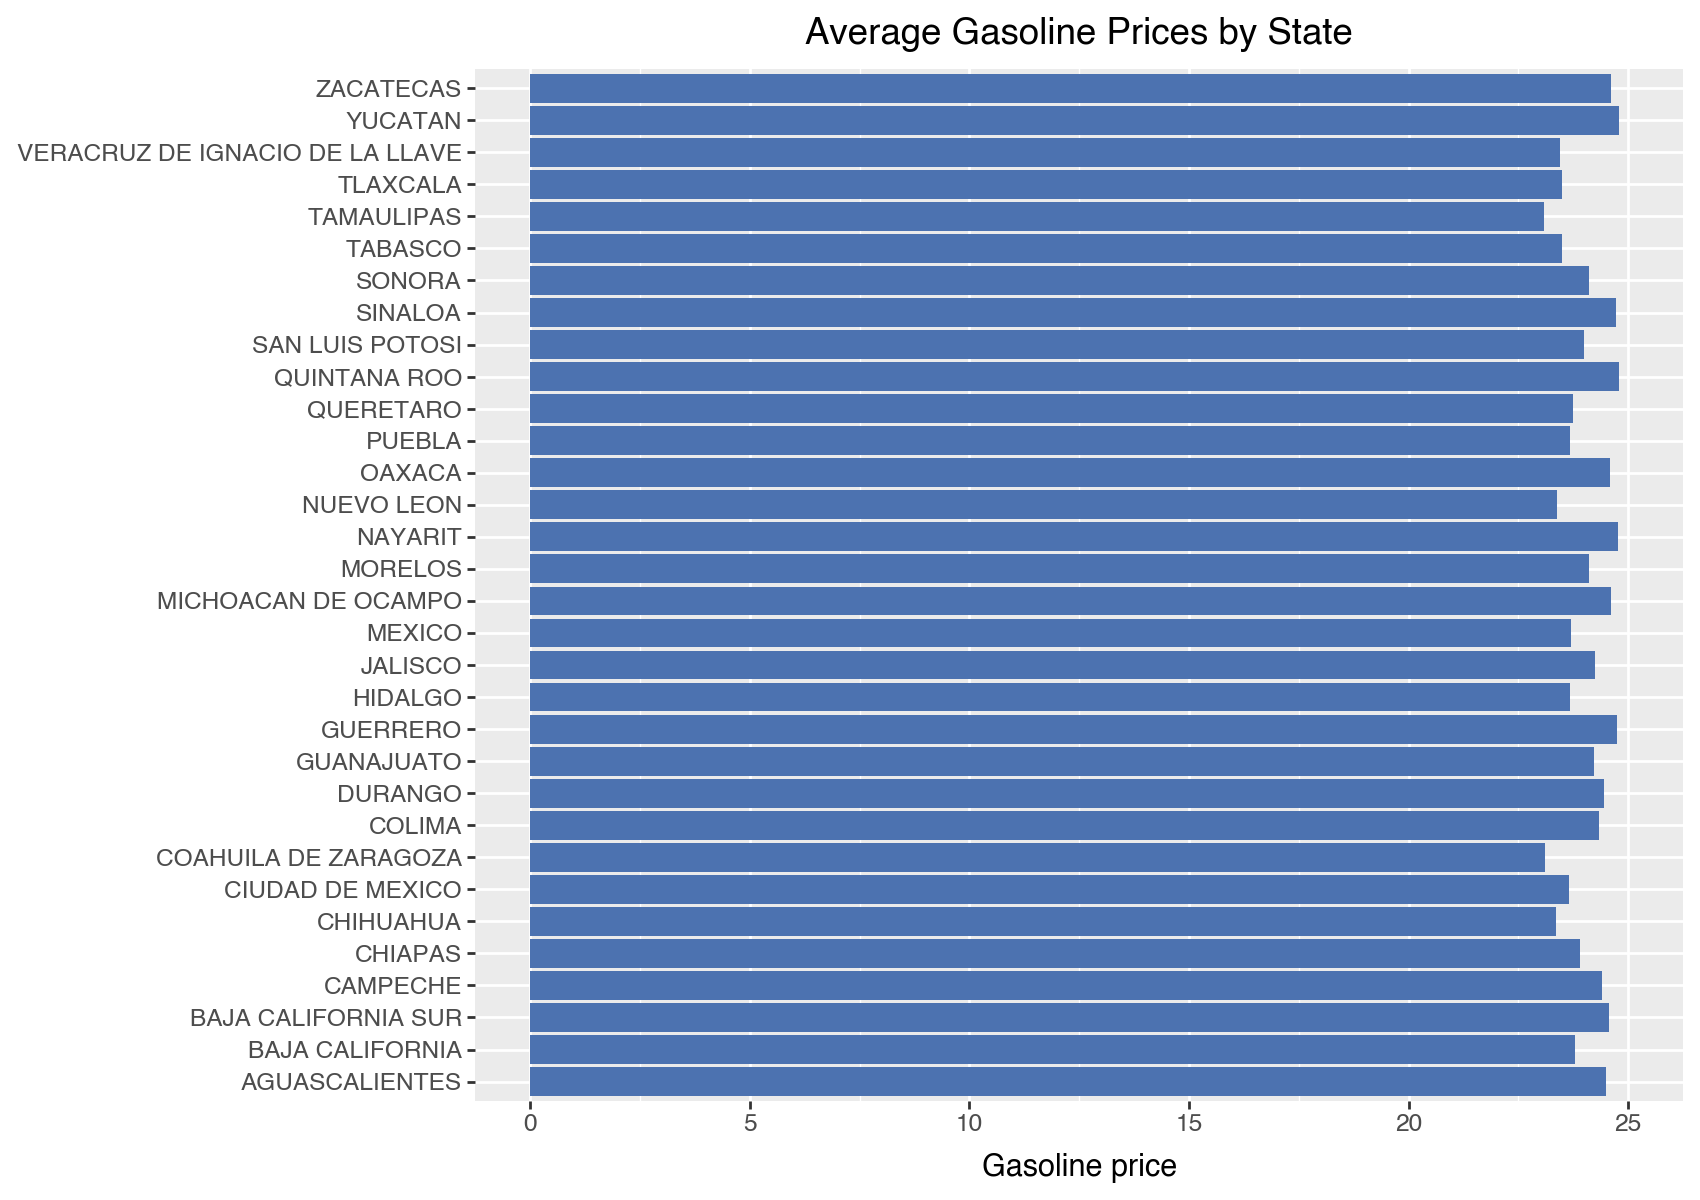

In [14]:
#| label: fig-states
#| fig-cap: Average Gasoline Prices by State

(
    ggplot(states, mapping=aes(x='state', y='sale_price'))
        + geom_bar(stat='identity', fill="#4c72b0")
        + coord_flip()
        + scale_y_continuous(limits=(0, 25))
        + labs(x='',
               y='Gasoline price',
              title='Average Gasoline Prices by State')
        + theme(axis_text_y=element_text(rotation=0),
               figure_size=(8.5, 6))
)

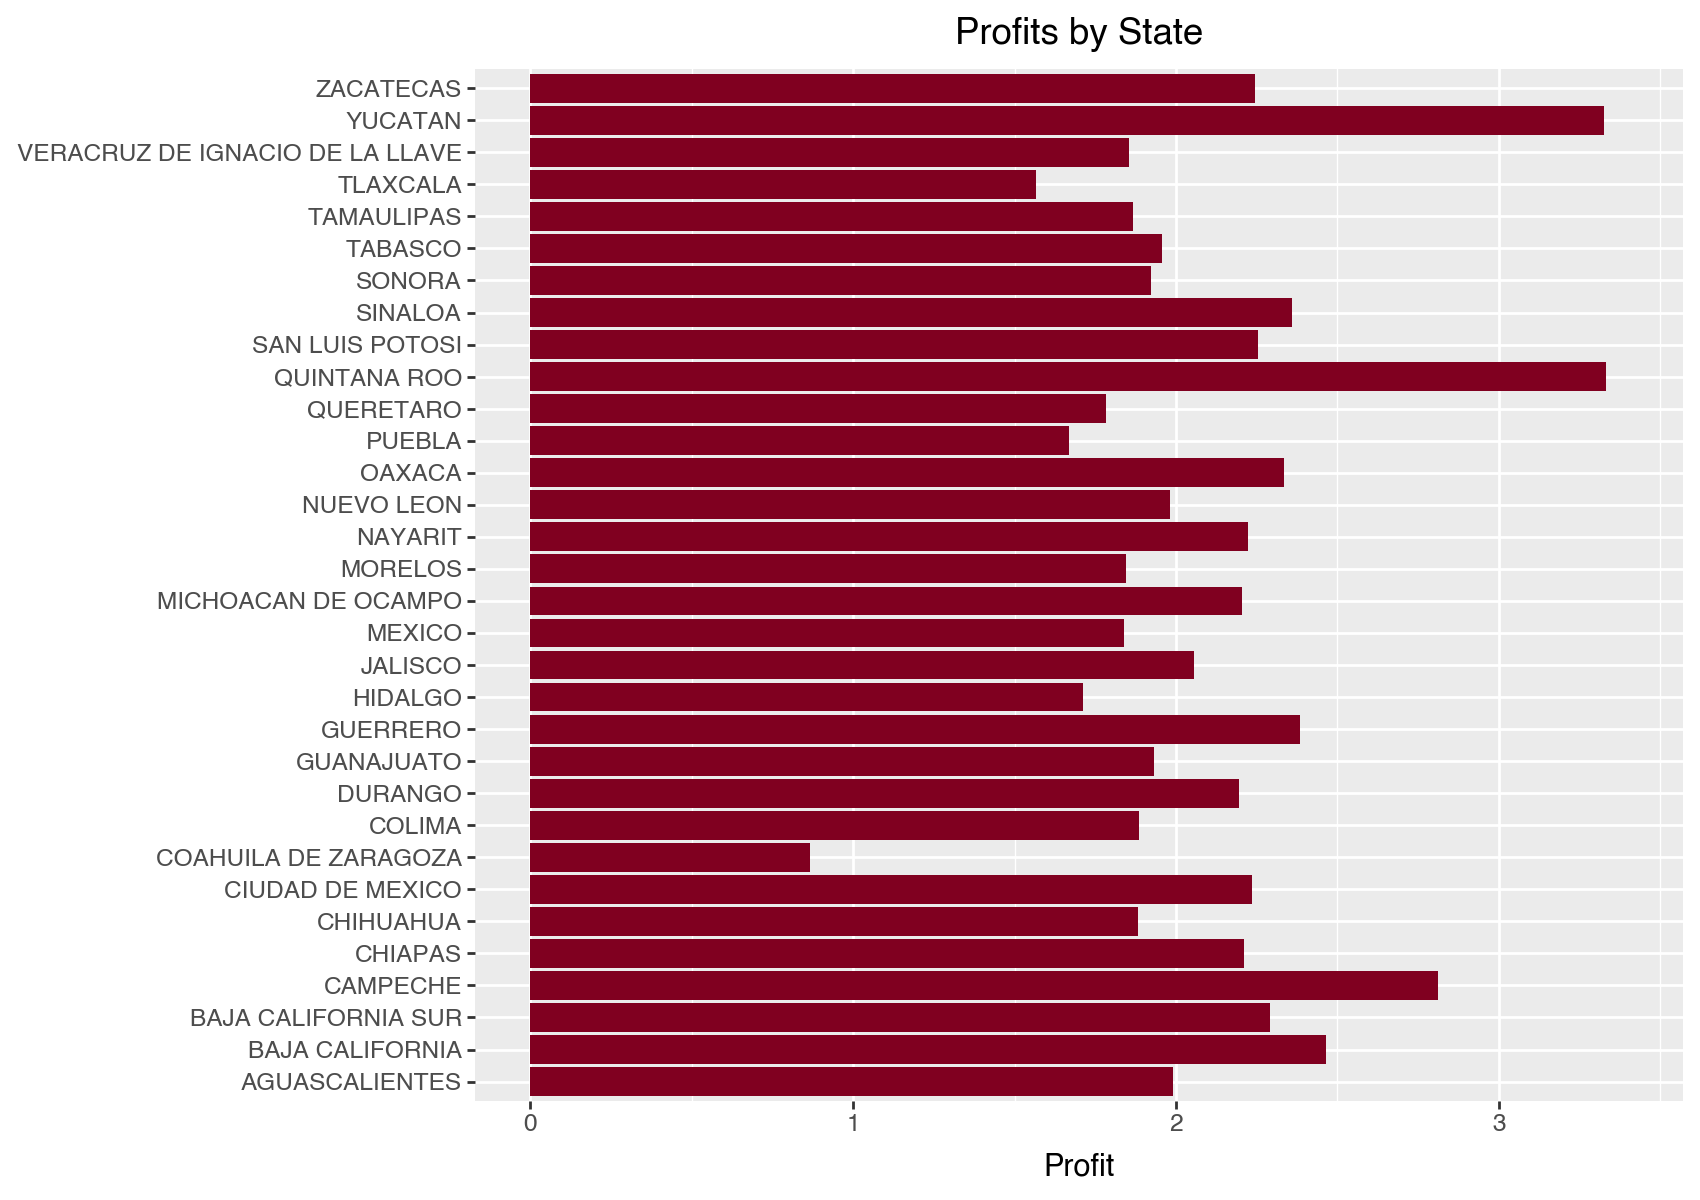

In [15]:
#| label: fig-states-profit
#| fig-cap: Profit by State

(
    ggplot(states, mapping=aes(x='state', y='profit'))
        + geom_bar(stat='identity', fill="#800020")
        + coord_flip()
        + scale_y_continuous(limits=(0, 3.4))
        + labs(x='',
               y='Profit',
               title='Profits by State')
        + theme(axis_text_y=element_text(rotation=0),
               figure_size=(8.5, 6))
)

## row {height=50%}

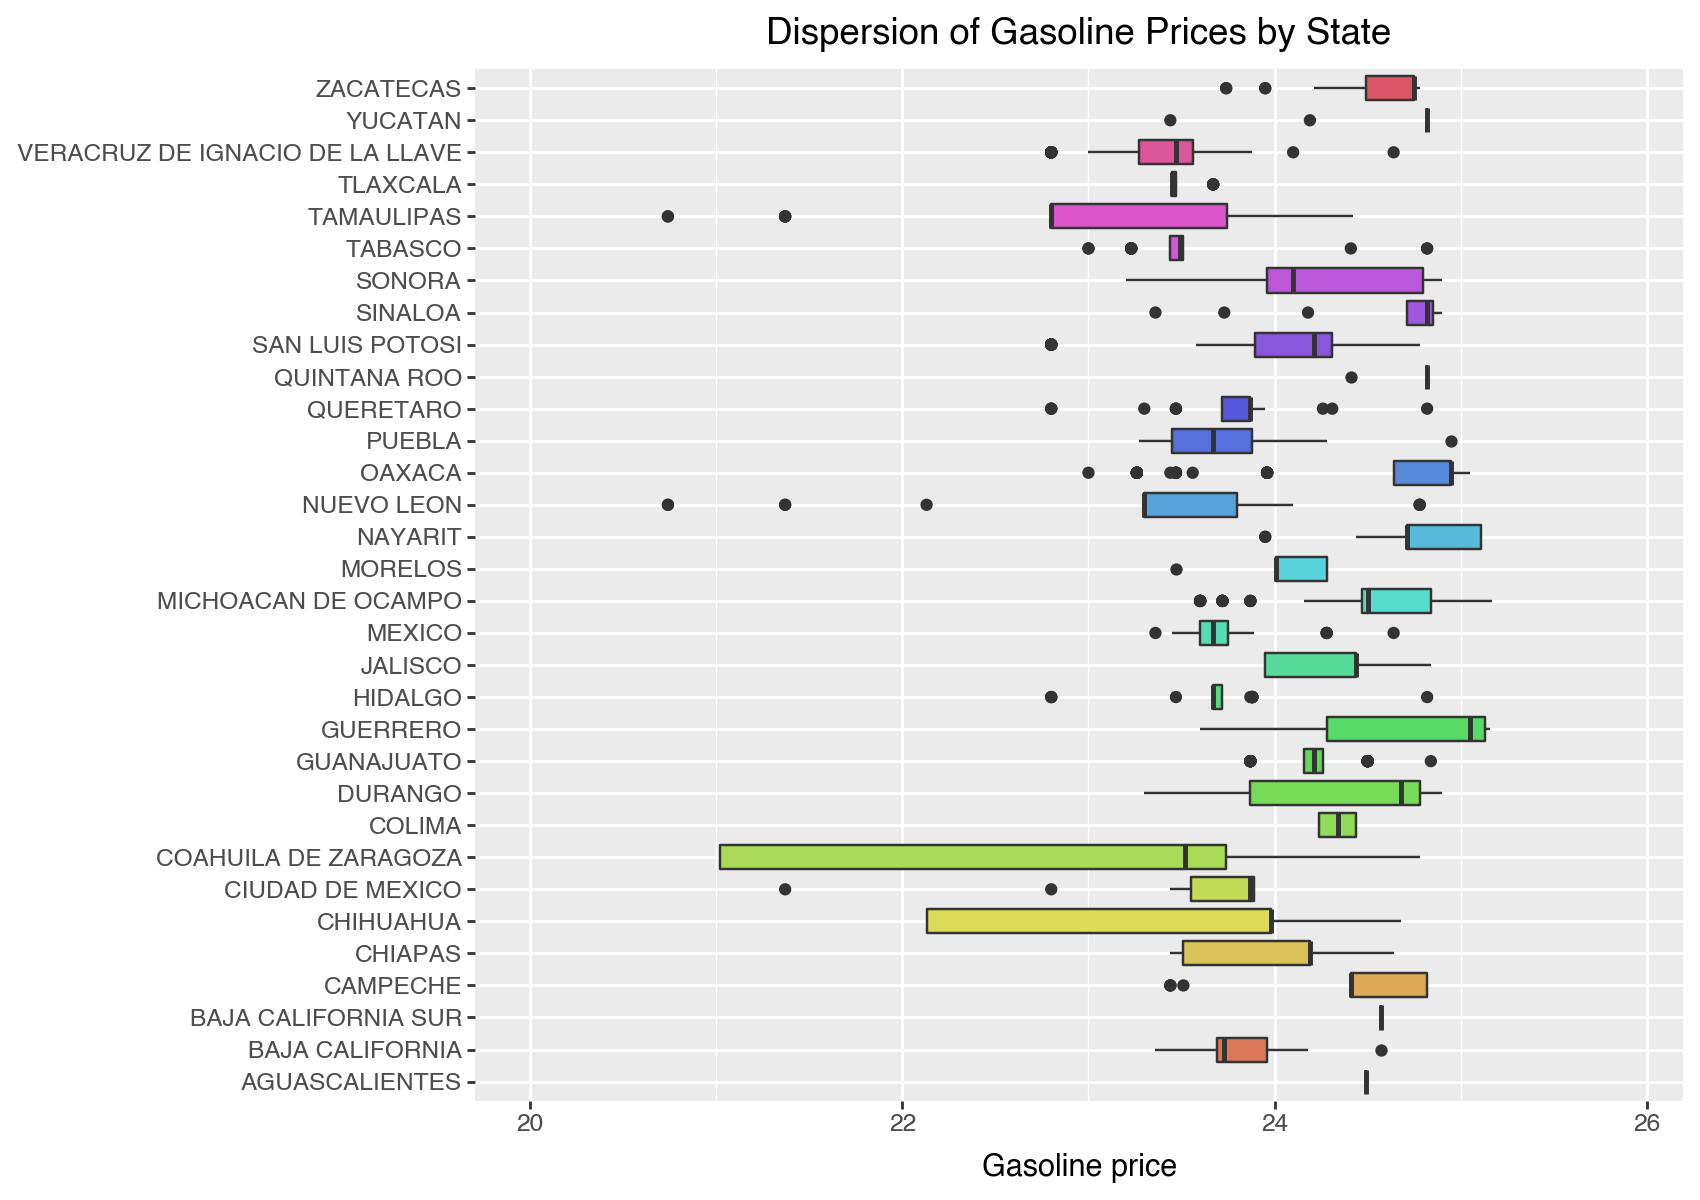

In [16]:
#| label: fig-municipalities
#| fig-cap: Dispersion of Gasoline Prices by State

(
    ggplot(data=df, mapping=aes(x='state', y='sale_price', fill='state')) 
    + geom_boxplot()
    + coord_flip()
    + scale_y_continuous(limits=(20, 25.9))
    + labs(x='',
           y='Gasoline price',
           title='Dispersion of Gasoline Prices by State')
    + theme(legend_position='none',
           figure_size=(8.5, 6))
)

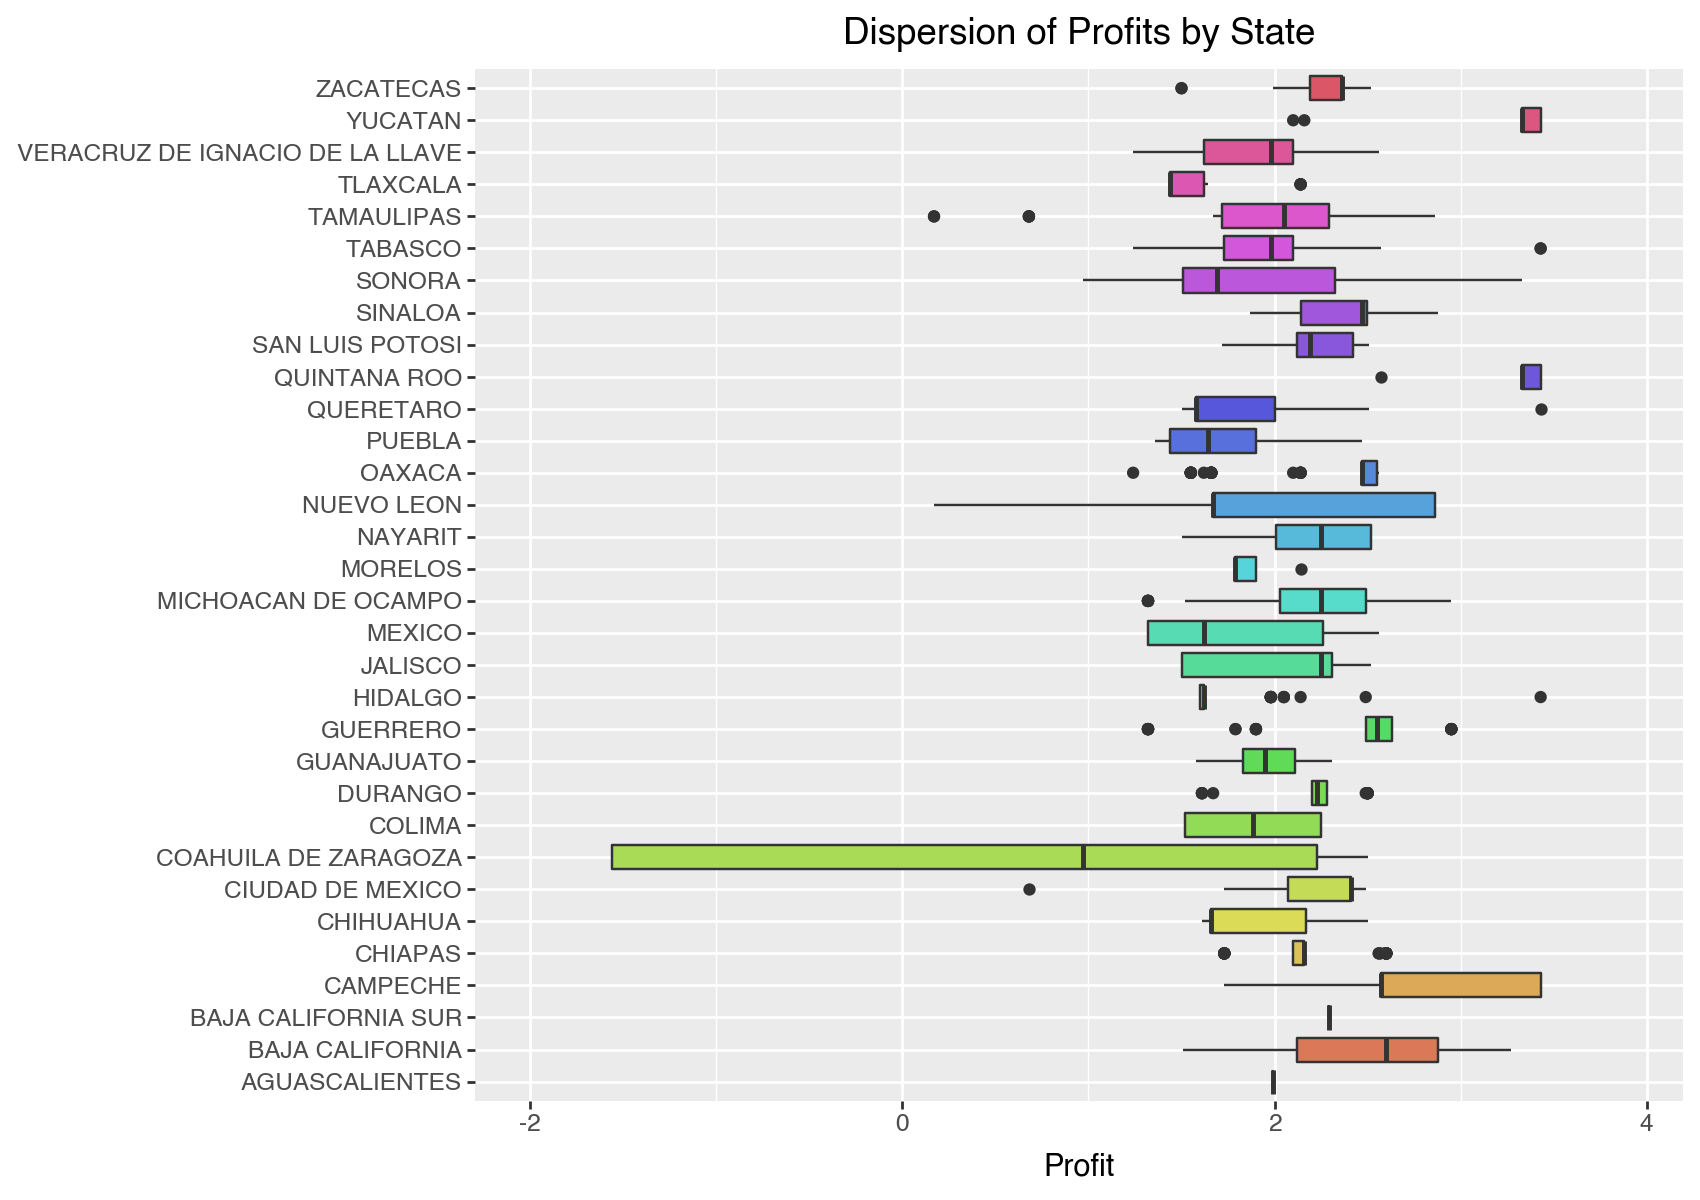

In [17]:
#| label: fig-municipalities-profit
#| fig-cap: Dispersion of Profits by State

(
    ggplot(data=df, mapping=aes(x='state', y='profit', fill='state')) 
    + geom_boxplot()
    + coord_flip()
    + scale_y_continuous(limits=(-2, 3.9))
    + labs(x='',
           y='Profit',
           title='Dispersion of Profits by State')
    + theme(legend_position='none',
           figure_size=(8.5, 6))
)